下ごしらえ

In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime
import time
import sys
# ライブラリまでのディレクトリ定義
#sys.path.append('../ml-scratch/utils') 
sys.path.append('../') # colaboratory用

import fc, get_mini_batch, relu, soft_max, sgd, he_initializer

Using TensorFlow backend.


## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [0]:
import numpy as np

class SimpleConv1d:
    """
    チャンネル数を1に限定した1次元畳み込み層クラス
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    stride : int
      ストライド
    """
    
    def __init__(self, W, B, optimizer, stride=1):
        self.W = W
        self.B = B
        self.stride = stride
        self.optimizer = optimizer
        self.X = None
        self.A = None
        self.dW = np.zeros(len(W))
        self.dX = None
        
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        
        self.X = X.copy()                                  # backwardで使うから
        A = np.array([])                                   # 返却用
        F_idx = np.arange(len(self.W))          # フィルタのindex
        
        # フィルタ終点がX終点にたどり着くまでやる
        while F_idx[-1] <= len(self.X) - 1:
            A = np.append(A, X[F_idx] @ self.W + self.B)
            # フィルタをストライド分移動
            F_idx += self.stride
            
        return A
    
    
    def backward(self, y, A):
        """
        バックワード
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes2)
            正解値
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        
        self.dX = np.zeros(len(self.X))         # 初期化
        self.dA = y - A                                     # パラメータ更新で使うためインスタンス変数化
        
        d_idx = np.arange(len(self.W))     # deltaX計算用index
        
        # deltaA分やる
        for s in range(len(self.dA)):
            self.dX[d_idx] += self.dA[s] * self.W
            d_idx += 1    # 右方向
                    
        # self.W self.Bの更新
        self = self.optimizer.update(self)
        
        return self.dX

In [0]:
import numpy as np

class SGDCNN:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        i_s_idx = np.arange(len(layer.W))     # deltaX計算用index
        
        # deltaA分やる
        for s in range(len(layer.dA)):
            layer.dW += layer.dA[s] * layer.X[i_s_idx]
            i_s_idx += 1     # 右方向
            
        layer.W -= self.lr * layer.dW                # 重さ更新
        
        layer.dB = np.sum(layer.dA, axis=0)
        layer.B -= self.lr * layer.dB                   # バイアス更新
        
        return layer

## 【問題2】1次元畳み込み後の出力サイズの計算

In [0]:
def calc_output_size(n_in_size, f_size, st_size=1, pd_size=0):
    return int(1 + (n_in_size + (2 * pd_size) - f_size / st_size))

## 【問題3】小さな配列での1次元畳み込み層の実験

In [5]:
x = np.array([1,2,3,4]).astype(np.float)    # float型じゃないとブロードキャストできない
w = np.array([3, 5, 7]).astype(np.float)     # めんどくさいのでクラスで型変換は後回し
b = 1

sc1 = SimpleConv1d(w, b, SGDCNN(0.1))
A = sc1.forward(x)
print('A : %s' % A)
print('A no outputsize : %s' % calc_output_size(len(sc1.X), len(sc1.W)))

# 誤差
y = np.array([45, 70])

dX = sc1.backward(y, A)
dW = sc1.dW
dB = sc1.dB
print('dW : %s' % dW)
print('dB : %s' % dB)
print('dX : %s' % dX)

A : [35. 50.]
A no outputsize : 2
dW : [ 50.  80. 110.]
dB : 30.0
dX : [ 30. 110. 170. 140.]


In [6]:
x = np.array([1,2,3,4,6,7]).astype(np.float)
w = np.array([3, 5, 7,9]).astype(np.float)
b = 1

sc1 = SimpleConv1d(w, b, SGDCNN(0.1))
A = sc1.forward(x)
print('A : %s' % A)
print('A no outputsize : %s' % calc_output_size(len(sc1.X), len(sc1.W)))

# 誤差
y = np.array([45, 70, 80])

dX = sc1.backward(y, A)
dW = sc1.dW
dB = sc1.dB
print('dW : %s' % dW)
print('dB : %s' % dB)
print('dX : %s' % dX)

A : [ 71. 104. 135.]
A no outputsize : 3
dW : [-259. -374. -544. -693.]
dB : -115.0
dX : [ -78. -232. -517. -747. -691. -495.]


## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
## 【問題8】（アドバンス課題）任意のストライド数

メモ：conv1D → H=1である必要がある

In [0]:
import numpy as np

class Conv1d:
    """
    チャンネル数を1に限定した1次元畳み込み層クラス
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    stride : int
      ストライド
    """
    
    def __init__(self, W, B, optimizer, stride=1, pad=0):
        self.W = W
        self.B = B
        self.stride = stride
        self.pad = pad
        self.optimizer = optimizer
        self.X = None
        self.A = None
        self.dW = None
        self.dX = None
        
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        
        if X.ndim < 3:
            X = X[np.newaxis, :, :]
            
        self.X = X.copy()                                  # backwardで使うから
        A = np.array([])                                   # 返却用
        
        S, C, W = X.shape
        FN, C, FW = self.W.shape
        
        col = np.empty((0, FW * C))
        col_W = self.W.reshape(FN, -1).T      # フィルタを平坦化
        F_idx = np.arange(FW)                         # フィルタのindex
        
        while F_idx[-1] <= W - 1:                      # フィルタ終点がX終点にたどり着くまでやる
            col = np.append(col, [X[:, :, F_idx].ravel()], axis=0)
            F_idx += self.stride
            
        A = col @ col_W + self.B
        
        self.AC, self.AW = A.T.shape
        
        return A.T
    
    
    def backward(self, A):
        """
        バックワード
        Parameters
        ----------
        y : 次の形のndarray, shape (batch_size, n_nodes2)
            正解値
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        self.dX = np.zeros(self.X.shape)         # 初期化
        self.dA = A.reshape((self.AC, self.AW))  # パラメータ更新で使うためインスタンス変数化
        
        S, C, W = self.dX.shape
        FN, C, FW = self.W.shape
        
        W = np.sum(self.W.reshape(FW, -1), axis=1)
        for i in range(S):                                            # バッチサイズ分ループ
            for j in range(C):                                        # チャンネル数分ループ
                d_idx = np.arange(FW)                        # deltaX計算用index
                for s in range(self.dA.shape[1]):
                    self.dX[i, j, d_idx] += np.sum(self.dA[:, s]) * W
                    d_idx += 1    # 右方向
        
        # self.W self.Bの更新
        self = self.optimizer.update(self)
        
        return self.dX

In [0]:
import numpy as np

class SGDCNN:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        FN, C, FW = layer.W.shape
        layer.dW = np.zeros((C, FW))
        
        for i in range(C):
            i_s_idx = np.arange(FW)     # deltaX計算用index
            for s in range(layer.dA.shape[1]):
                layer.dW[i] += np.sum(layer.dA[:, s]) * np.sum(layer.X[:, i, i_s_idx], axis=0)
                i_s_idx += 1     # 右方向
            
        layer.W -= self.lr * layer.dW                # 重さ更新
        
        layer.dB = np.sum(layer.dA, axis=1)
        layer.B -= self.lr * layer.dB                   # バイアス更新
        
        return layer

In [9]:
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]]).astype(np.float) # shape(1, 2, 4)で、（バッチサイズ, 入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)).astype(np.float) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]).astype(np.float) # （出力チャンネル数）
c1 = Conv1d(w, b, SGDCNN(0.1))
A = c1.forward(x)

A = A.ravel()

dX = c1.backward(A)

print('A : %s' % A.T)
print('dW : %s' % c1.dW)
print('W : %s' % c1.W)
print('dB : %s' % c1.dB)
print('B : %s' % c1.B)
print('dX : %s' % dX)

A : [16. 22. 17. 23. 18. 24.]
dW : [[189. 309. 429.]
 [309. 429. 549.]]
W : [[[-17.9 -29.9 -41.9]
  [-29.9 -41.9 -53.9]]

 [[-17.9 -29.9 -41.9]
  [-29.9 -41.9 -53.9]]

 [[-17.9 -29.9 -41.9]
  [-29.9 -41.9 -53.9]]]
dB : [38. 40. 42.]
B : [-2.8 -2.  -1.2]
dX : [[[306. 720. 720. 414.]
  [306. 720. 720. 414.]]]


In [10]:
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6]]]).astype(np.float)
w = np.ones((4, 3, 3)).astype(np.float)
b = np.array([1, 2, 3, 4]).astype(np.float)

c1 = Conv1d(w, b, SGDCNN(0.1))
A = c1.forward(x)

dX = c1.backward(A)

print('A : %s' % A)
print('dW : %s' % c1.dW)
print('dB : %s' % c1.dB)
print('dX : %s' % dX)

A : [[28. 37.]
 [29. 38.]
 [30. 39.]
 [31. 40.]]
dW : [[ 426.  698.  970.]
 [ 698.  970. 1242.]
 [ 970. 1242. 1514.]]
dB : [65. 67. 69. 71.]
dX : [[[1416. 3264. 3264. 1848.]
  [1416. 3264. 3264. 1848.]
  [1416. 3264. 3264. 1848.]]]


## 【問題5】学習・推定
## CNN分類器クラスの作成
- バッチサイズ1にしか対応していないため、X_trainのsample数を60000 → 6000に変更して行う

In [0]:
import numpy as np
import logging                                                                     # ログ
from datetime import datetime                                        # 時間のやつ
from sklearn.preprocessing import OneHotEncoder       # ワンホットのやつ
from tqdm import tqdm                                                     # 進捗バーを出してくれるやつ


class Scratch1dCNNClassifier():
    """
    ニューラルネットワーク分類器
    """

    def __init__(self, batch_size=1, n_epochs=5,  n_nodes=200, layer=4, verbose=True,
                            sigma=1e-2, lr=1e-2, filter_n=3, filter_w=3, filter_c=1, activation=None, optimizer='sgd'):

        self.batch_size = batch_size     # バッチサイズ
        self.n_epochs = n_epochs         # エポック数 
        self.n_input = n_nodes              # 初回のノード数
        self.layer = layer                          # 層の数
        self.verbose = verbose               # 学習過程出力フラグ
        self.activation = activation        #活性化関数(文字列)
        self.lr = lr                                      # 学習率
        self.filter_n = filter_n                 # フィルタ枚数
        self.filter_w = filter_w                # フィルタwidth
        self.filter_c = filter_c                  # フィルタチャネル数
        self.layer_instances = []             # 各層インスタンス格納用
        self.activations = []                     # 活性化関数インスタンス格納用
        self.loss_ = []                              # 学習用データの学習過程格納用
        self.loss_val_ = []                       # 検証用データの学習過程格納用
        
        # 初期化・最適化クラスインスタンス作成
        if activation == 'relu':
            self.initializer = he_initializer.HeInitializer()
        else:
            self.initializer = XavierInitializer()
        
        if optimizer == 'sgd':
            self.optimizer = sgd.SGD(lr)
        elif optimizer == 'adagrad':
            self.optimizer = AdaGrad(lr)
            
        # ワンホットライブラリのインスタンス作成
        self.enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        
        # ログレベルを DEBUG に変更
        time_stamp = datetime.now().strftime('%Y%m%d')
        logging.basicConfig(filename='../tmp/sprint11_' + time_stamp + '.log', level=logging.DEBUG)
        
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        
        # ワンホット化
        y = self.enc.fit_transform(y[:, np.newaxis])
        
        # 検証用データがある場合
        if X_val is not None:
            y_val= self.enc.fit_transform(y_val[:, np.newaxis])

        # 初期化
        n_nodes1 = self.n_input
        out_w = calc_output_size(X.shape[2], 3)
        n_features = out_w * self.filter_n
        n_output = y.shape[1]
        
        # 各層のFCインスタンス作成
        for i in range(self.layer):
            if i == (self.layer - 1):     # 出力層
                ins = fc.FC(n_nodes2, n_output, self.initializer, self.optimizer)
                act_ins = soft_max.Softmax()
            else:
                if i == 0:                       # 入力層(conv)
                    W = np.ones((self.filter_n, self.filter_c, self.filter_w)).astype(np.float)
                    b = np.ones(self.filter_n).astype(np.float)
                    ins = Conv1d(W, b, SGDCNN(self.lr))
                elif i == 1:
                    ins = fc.FC(n_features, n_nodes1, self.initializer, self.optimizer)
                else:
                    n_nodes2 = int(n_nodes1 / 2)
                    ins = fc.FC(n_nodes1, n_nodes2, self.initializer, self.optimizer)
                    n_nodes1 = n_nodes2
                
                # 出力層以外は指定された活性化関数をインスタンス化
                if self.activation == 'sigmoid':
                    act_ins = sigmoid.Sigmoid()
                elif self.activation == 'tanh':
                    act_ins = tanh.Tanh()
                elif self.activation == 'relu':
                    act_ins = relu.ReLU()
                
            self.layer_instances.append(ins)                           # 各自格納
            self.activations.append(act_ins)


        for e in tqdm(range(self.n_epochs)):
            # ミニバッチ化
            gmb = get_mini_batch.GetMiniBatch(X, y, batch_size=self.batch_size)
            # ロス格納用
            loss_ary = []
            
            # Xのn_samples / batch_size数分ループ処理
            for mini_X_train, mini_y_train in gmb:
                # forward propagation
                for i in range(self.layer):
                    if i == 0:                              # 入力層
                        A = self.layer_instances[i].forward(mini_X_train)
                        A = A.ravel()[np.newaxis, :]
                        Z = self.activations[i].forward(A)
                    else:
                        A = self.layer_instances[i].forward(Z)
                        Z = self.activations[i].forward(A)
                
                # back propagation
                for i in range(self.layer):
                    n_FC = self.layer - i - 1      # インスタンス逆指定用
                    if i == 0:                               # 出力層
                        dA, loss = self.activations[n_FC].backward(Z, mini_y_train)
                        loss_ary.append(loss)
                    else:                                     # 入力層
                        dA = self.activations[n_FC].backward(dZ)
                        
                    dZ = self.layer_instances[n_FC].backward(dA)

                    
            #誤差を格納
            self.loss_.append(np.mean(loss_ary))
                        
            # 検証用データがある場合
            if X_val is not None:
                # forward propagation
                for i in range(self.layer):
                    if i == 0:                              # 入力層
                        A = self.layer_instances[i].forward(X_val)
                        A = A.ravel()[np.newaxis, :]
                        Z = self.activations[i].forward(A)
                    else:
                        A = self.layer_instances[i].forward(Z)
                        Z = self.activations[i].forward(A)
                
                dA, loss_val = self.activations[self.layer-1].backward(Z, y_val)

                #誤差を格納
                self.loss_val_.append(np.mean(loss_val))
                            

            # フラグがTrueであればログ出力
            if self.verbose:
                logging.info('forward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(A), A.shape)
                logging.info('forward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(Z), Z.shape)
                logging.info('backward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(dA), dA.shape)
                logging.info('backward propagation %sエポック目 sum: %s shape: %s', e+1, np.sum(dZ), dZ.shape)
                logging.info('loss %sエポック目 : %s', e+1, np.sum(loss))

        return self


    def predict(self, X, y):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習データ

        Returns
        -------
        y_pred :  次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        
        # ミニバッチ化
        gmb = get_mini_batch.GetMiniBatch(X, y, batch_size=self.batch_size)
        # ロス格納用
        y_pred = np.empty(len(y))
        print(y_pred.shape)
        cnt = 0

        # Xのn_samples / batch_size数分ループ処理
        for mini_X_train, _ in gmb:
            for i in range(self.layer):
                if i == 0:                              # 入力層
                    A = self.layer_instances[i].forward(mini_X_train)
                    A = A.ravel()[np.newaxis, :]
                    Z = self.activations[i].forward(A)
                else:
                    A = self.layer_instances[i].forward(Z)
                    Z = self.activations[i].forward(A)
                
            y_pred[cnt] = np.argmax(Z[0], axis=0)
            cnt += 1
            
        # 一番確率が高いラベルを予測値に
        
        
        return y_pred
    

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平坦化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# どでかいので少なくする
X_train = X_train[:3000, np.newaxis, :]
y_train = y_train[:3000]

# 学習データをスプリット
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [13]:
sdnnc= Scratch1dCNNClassifier(activation='relu')

sdnnc.fit(X_train, y_train)

100%|██████████| 5/5 [09:56<00:00, 119.34s/it]


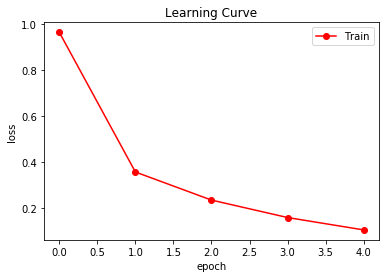

In [14]:
train_loss = np.array(sdnnc.loss_)

plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score
plt.plot(train_loss, 'o-', color="r", label="Train")

plt.legend(loc=1)
plt.show()

In [15]:
# 予測
y_pred = sdnnc.predict(X_val, y_val)
print(y_pred)
print(confusion_matrix(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

(600,)
[5. 6. 7. 8. 2. 2. 6. 3. 7. 7. 5. 0. 0. 1. 8. 9. 9. 2. 0. 1. 6. 6. 1. 5.
 9. 3. 1. 9. 1. 9. 5. 0. 9. 0. 5. 7. 2. 4. 3. 1. 3. 6. 4. 6. 2. 0. 0. 9.
 3. 1. 0. 0. 4. 6. 6. 4. 3. 5. 8. 1. 1. 8. 8. 1. 4. 4. 5. 1. 3. 4. 3. 4.
 2. 1. 1. 3. 1. 2. 8. 7. 4. 3. 2. 0. 6. 1. 0. 6. 5. 9. 0. 2. 2. 4. 2. 1.
 0. 0. 5. 0. 5. 3. 0. 6. 5. 2. 2. 0. 6. 0. 1. 1. 7. 6. 8. 5. 6. 7. 7. 6.
 0. 1. 0. 4. 3. 0. 7. 1. 4. 2. 2. 2. 5. 6. 6. 7. 4. 0. 1. 4. 9. 2. 6. 0.
 1. 2. 6. 3. 1. 0. 4. 6. 3. 9. 6. 3. 9. 8. 3. 8. 4. 3. 6. 3. 6. 5. 9. 9.
 6. 1. 7. 0. 4. 6. 4. 8. 9. 7. 4. 1. 9. 4. 6. 5. 3. 7. 4. 5. 5. 9. 4. 9.
 2. 8. 2. 8. 6. 4. 8. 4. 8. 2. 6. 4. 3. 3. 1. 3. 7. 3. 4. 3. 5. 7. 8. 2.
 5. 4. 6. 5. 5. 2. 6. 9. 9. 0. 1. 6. 5. 0. 0. 5. 2. 7. 3. 1. 2. 2. 7. 0.
 5. 1. 5. 3. 4. 9. 5. 3. 1. 7. 1. 2. 4. 7. 7. 7. 0. 4. 3. 1. 8. 3. 9. 5.
 4. 5. 5. 0. 7. 2. 7. 9. 9. 1. 7. 1. 2. 3. 0. 6. 1. 1. 2. 4. 6. 3. 9. 0.
 9. 2. 4. 5. 1. 2. 0. 7. 1. 7. 3. 8. 2. 8. 3. 2. 4. 1. 4. 1. 8. 0. 5. 7.
 4. 9. 0. 2. 6. 7. 6. 1. 3. 2. 9. 8. 8. 8. 3

ひどい。  
<br>
ものすごい学習に時間がかかるため
- バッチサイズを大きくする
- パディングを行う
- 2d以上にする  
場合は畳み込み時の処理を最適化(=im2col, col2imなどのライブラリを使う？)必要がありそうと感じた  
<br>

- 【問題6】（アドバンス課題）パディングの実装
- 【問題7】（アドバンス課題）ミニバッチへの対応  
上記はim2col, col2im を使う以外やり方が思いつかなかった(かといってfor文ループはあまりやりたくない。。)ので、飛ばしてしまった  
次回sprint13は各ライブラリを使うことを前提とし、やってることを深掘りし理解を補完したい